# 准备

In [1]:
import os
import sys

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plt_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w, h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h), (x*(w+pad)+pad):(x*(w+pad)+pad+w)]=images[y*n_cols+x]
        plt.imshow(image, cmap="Greys", interpolation="nearest")
        plt.axis("off")

# 使用线性Autoencoder进行主成分分析(PCA)

In [2]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [4]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [5]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
        coding_val = codings.eval(feed_dict={X: X_test})

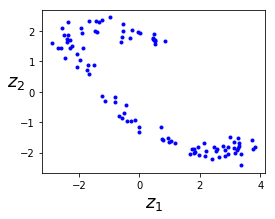

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(coding_val[:, 0], coding_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

# Stacked Autoencoders

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist  = input_data.read_data_sets("tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 一次性训练所有层

In [8]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_all_layers.ckpt")

09% Train MSE: 0.020302307
1 Train MSE: 0.011643166
29% Train MSE: 0.010225781
39% Train MSE: 0.009899946
49% Train MSE: 0.010377405


In [10]:
def show_reconstruction_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from autoencoder/my_model_all_layers.ckpt


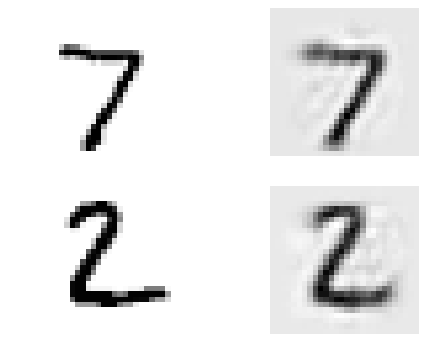

In [11]:
show_reconstruction_digits(X, outputs, "autoencoder/my_model_all_layers.ckpt")

## 调整权重

In [12]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [13]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [14]:
saver = tf.train.Saver()

In [15]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_tying_weights.ckpt")

09% Train MSE: 0.015066842
19% Train MSE: 0.016488561
29% Train MSE: 0.017375803
3 Train MSE: 0.016878227
49% Train MSE: 0.015587644


INFO:tensorflow:Restoring parameters from autoencoder/my_model_tying_weights.ckpt


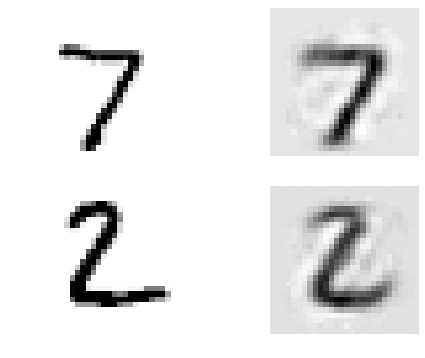

In [16]:
show_reconstruction_digits(X, outputs, "autoencoder/my_model_tying_weights.ckpt")

## Training one Autoencoder at a time in multiple graphs

In [17]:
reset_graph()

In [18]:
from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                     learning_rate=0.01, l2_reg=0.0005, seed=42,
                     hidden_activation=tf.nn.elu,
                     output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
        )
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            init.run()
            for epoch in range(n_epochs):
                n_batches = len(X_train) // batch_size
                for iteration in range(n_batches):
                    print("\r{}%".format(100 * iteration // n_batches), end="")
                    sys.stdout.flush()
                    indices = rnd.permutation(len(X_train))[:batch_size]
                    X_batch = X_train[indices]
                    sess.run(training_op, feed_dict={X: X_batch})
                loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
                print("\r{}".format(epoch), "Train MSE:", loss_train)
            params = dict([(var.name, var.eval()) 
                           for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
            hidden_val = hidden.eval(feed_dict={X: X_train})
            return hidden_val, params["hidden/kernel:0"],params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [19]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images,
                                                  n_neurons=300, n_epochs=4,
                                                  batch_size=150, output_activation=None)
_, W2,b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, 
                                     n_epochs=4, batch_size=150)

09% Train MSE: 0.018517738
19% Train MSE: 0.0186826
29% Train MSE: 0.018467626
39% Train MSE: 0.019231623
09% Train MSE: 0.0042361086
1 Train MSE: 0.0048326803
29% Train MSE: 0.004668748
39% Train MSE: 0.0044039097


In [20]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

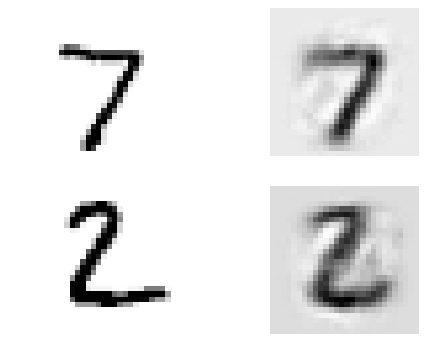

In [21]:
show_reconstruction_digits(X, outputs)

## Training one Autoencoder at a time in a single graph

In [22]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weigths2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.name_scope("phase1"):
    phasel_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phasel_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

In [24]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_loesses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase],feed_dict={X: X_batch})
            loss_train = reconstruction_loesses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Training MSE:", loss_train)
            saver.save(sess, "autoencoder/my_model_one_at_a_time.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
        print("Test MSE:", loss_test)

Training phase #1
0 Training MSE: 0.0074068382
19% Training MSE: 0.0078287525
29% Training MSE: 0.007728059
3 Training MSE: 0.0074089756
Test MSE: 0.10580704
Training phase #2
0 Training MSE: 0.3257823
19% Training MSE: 0.00573954
29% Training MSE: 0.0029418417
39% Training MSE: 0.0024437662
Test MSE: 0.009793411


## 缓存冻结的层输出

In [27]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_loesses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_loesses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "autoencoder/my_mode_cache_frozen.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
        print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.007538227
19% Train MSE: 0.007754632
29% Train MSE: 0.007343643
39% Train MSE: 0.007837738
Test MSE: 0.10728952
Training phase #2
09% Train MSE: 0.16884093
1 Train MSE: 0.0044883126
29% Train MSE: 0.0024808452
39% Train MSE: 0.0020300867
Test MSE: 0.009770555


## 可视化重构

INFO:tensorflow:Restoring parameters from autoencoder/my_model_one_at_a_time.ckpt


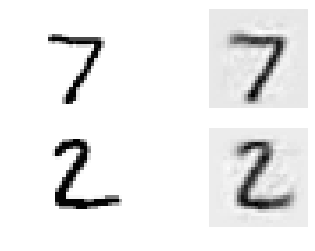

In [28]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "autoencoder/my_model_one_at_a_time.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test})
    
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## 可视化另外的特征

INFO:tensorflow:Restoring parameters from autoencoder/my_model_one_at_a_time.ckpt


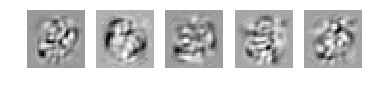

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "autoencoder/my_model_one_at_a_time.ckpt")
    weights_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights_val.T[i])

## 非监督的预训练

In [30]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [31]:
n_epochs = 4
batch_size = 150
n_labeled_instance = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instance // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instance)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Traing accuracy:", accuracy_val, end="")
        saver.save(sess, "autoencoder/my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Traing accuracy: 0.94Test accuracy: 0.9247
19% Traing accuracy: 0.97333336Test accuracy: 0.9328
29% Traing accuracy: 0.9866667Test accuracy: 0.9406
39% Traing accuracy: 0.98Test accuracy: 0.9423


In [32]:
n_epochs = 4
batch_size = 150
n_labeled_instance = 2000
with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "autoencoder/my_model_supervised.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instance // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instance)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Traing accuracy:", accuracy_val, end="")
        saver.save(sess, "autoencoder/my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from autoencoder/my_model_supervised.ckpt
02% Traing accuracy: 0.9533333Test accuracy: 0.8857
12% Traing accuracy: 0.9866667Test accuracy: 0.929
2 Traing accuracy: 1.0Test accuracy: 0.936
32% Traing accuracy: 1.0Test accuracy: 0.9339


# Denoising Autoencoders

In [34]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [35]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.elu,
                         name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu,
                         name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu,
                         name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [38]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_stacked_denosing_gaussian.ckpt")

0 Train MSE: 0.04977927
19% Train MSE: 0.038982198
2 Train MSE: 0.039030865
39% Train MSE: 0.03734642
49% Train MSE: 0.03668023
59% Train MSE: 0.035559937
69% Train MSE: 0.0350719
79% Train MSE: 0.034988243
89% Train MSE: 2880.0566
99% Train MSE: 0.4635606


## 使用dropout

In [39]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [40]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name="training")

X = tf.placeholder(tf.float32, [None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                         name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                         name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                         name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch  = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training:True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "autoencoder/my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.032408424
19% Train MSE: 0.030642783
29% Train MSE: 0.03021327
3 Train MSE: 0.028293274
49% Train MSE: 0.02634019
59% Train MSE: 0.028265141
69% Train MSE: 0.027054232
79% Train MSE: 0.028730463
89% Train MSE: 0.029221121
99% Train MSE: 0.02852648


INFO:tensorflow:Restoring parameters from autoencoder/my_model_stacked_denoising_dropout.ckpt


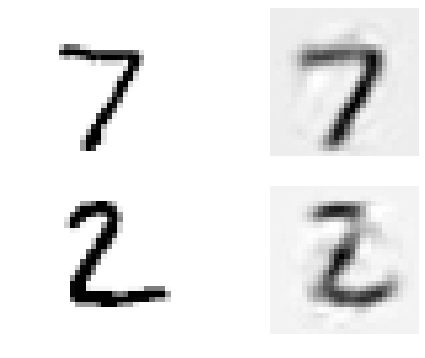

In [44]:
show_reconstruction_digits(X, outputs, "autoencoder/my_model_stacked_denoising_dropout.ckpt")